# ***תרגיל 5 של הפרוייקט***

**Load Data and Basic Setup**

In [16]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv("/content/train-filtered_question_level.csv")

# Remove duplicate questions
df = df.drop_duplicates(subset=["question"], keep="first")

# Extract text and difficulty levels
texts = df["question"].astype(str).tolist()
levels = df["level"].tolist()


**Balancing Dataset (Undersampling to Minority Class)**

In [17]:
# import pandas as pd

# # 1. נגדיר את גודל היעד לפי המחלקה הקטנה ביותר (Hard)
# target_size = 15657

# # 2. נבצע דגימה מכל מחלקה בנפרד
# df_hard = df[df['level'] == 'hard']
# # כאן אנחנו לא עושים sample כי זה כבר הגודל שאנחנו רוצים

# df_medium_downsampled = df[df['level'] == 'medium'].sample(n=target_size, random_state=42)
# df_easy_downsampled = df[df['level'] == 'easy'].sample(n=target_size, random_state=42)

# # 3. נחבר את שלושתן יחד
# df_balanced = pd.concat([df_hard, df_medium_downsampled, df_easy_downsampled])

# # 4. נערבב את הדאטה (חשוב מאוד!)
# df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# # בדיקת תוצאה
# print("התפלגות חדשה:")
# print(df_balanced['level'].value_counts())

In [50]:
import pandas as pd

# 1. הגדרת גודל המדגם לכל קטגוריה (היפר-פרמטר של שלב הניסויים)
# התחלה עם 1000 מכל אחת עוזרת לבדיקה מהירה ("מתחילים בקטן" לפי ההוראות)
target_size = 7000

# 2. דגימה מאוזנת מכל הקטגוריות בבת אחת
# groupby מבטיח שנתייחס לכל רמת קושי בנפרד
df_balanced = df.groupby('level').apply(lambda x: x.sample(n=target_size, random_state=42)).reset_index(drop=True)

# 3. ערבוב הדאטה (Shuffle) - קריטי בלמידה עמוקה!
# כדי שה-Batch לא יכיל רק מחלקה אחת בזמן האימון, מה שיהרוס את הלמידה
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# בדיקת התפלגות כפי שנדרש בשלב ה-EDA ובניתוח הדאטה
print("התפלגות חדשה ומאוזנת:")
print(df_balanced['level'].value_counts())

התפלגות חדשה ומאוזנת:
level
easy      7000
medium    7000
hard      7000
Name: count, dtype: int64


/tmp/ipython-input-1049390522.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('level').apply(lambda x: x.sample(n=target_size, random_state=42)).reset_index(drop=True)


In [66]:
import numpy as np

# זיהוי אוטומטי של עמודת הטקסט (מחפש עמודה שהיא אובייקט/סטרינג ואינה 'level')
text_col = [c for c in df_balanced.columns if df_balanced[c].dtype == 'object' and c != 'level'][0]
print(f"מנתח נתונים לפי עמודה: {text_col}")

# חישוב מדדים סטטיסטיים
df_balanced['word_count'] = df_balanced[text_col].apply(lambda x: len(str(x).split()))
df_balanced['avg_word_length'] = df_balanced[text_col].apply(lambda x: np.mean([len(w) for w in str(x).split()]) if len(str(x).split()) > 0 else 0)

# 1. הדפסת דוגמאות אמיתיות לדו"ח
print("\n" + "="*50)
print("🔹 דוגמאות מייצגות לכל רמה (לצורך ניתוח איכותני)")
print("="*50)
for level in sorted(df_balanced['level'].unique()):
    print(f"\n📌 רמה: {level}")
    samples = df_balanced[df_balanced['level'] == level][text_col].head(3).values
    for i, s in enumerate(samples, 1):
        print(f"  {i}. {s[:150]}...") # מדפיס רק את תחילת המשפט

# 2. טבלת השוואה סטטיסטית
print("\n" + "="*50)
print("📊 מדדים לשוניים ממוצעים לכל רמה")
print("="*50)
comparison = df_balanced.groupby('level').agg({
    'word_count': 'mean',
    'avg_word_length': 'mean'
}).rename(columns={'word_count': 'ממוצע מילים למשפט', 'avg_word_length': 'אורך מילה ממוצע'}).round(2)

print(comparison)

מנתח נתונים לפי עמודה: question

🔹 דוגמאות מייצגות לכל רמה (לצורך ניתוח איכותני)

📌 רמה: easy
  1. This is a list of NFL Draft selections by the Indianapolis Colts, the first draft that the current incarnation of the Colts franchise participated in ...
  2. In late December 1980, there were a series of reported sightings of unexplained lights near Rendlesham Forest, Suffolk, England, which have become lin...
  3. What country was the businessman who founded an American hip hop apparel company? ...

📌 רמה: hard
  1. What party is the governor who Karen Jackson served as Deputy Secretary of Technology under?...
  2. Where both Games Magazine and The General published by Games Publications?...
  3. The Devonwood Bike Trail serves the shopping mall in Windsor, Ontario, Canada and which airport?...

📌 רמה: medium
  1. The Prince of the Pagodas's music was commissioned from a composer who passed away in which year ?...
  2. when was thevAmerican composer of music for films, who produced Lost

# **שלב 1**

# **א**

**Choosing Maximum Sequence Length (Documentation)**

In [51]:
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np

# 1. הגדרת פרמטרים
VOCAB_SIZE = 20000

# 2. אתחול הטוקנייזר (יצירת האובייקט שהיה חסר)
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")

# 3. חילוץ הטקסטים מהדאטה המאוזן (ודא ששם העמודה נכון, נניח 'text')
texts = df_balanced['question'].astype(str).tolist()

# 4. התאמת הטוקנייזר על הטקסטים (שלב קריטי!)
tokenizer.fit_on_texts(texts)

# 5. המרה לרצפים של מספרים
sequences = tokenizer.texts_to_sequences(texts)

# עכשיו הסטטיסטיקות שלך יעבדו:
sequence_lengths = [len(seq) for seq in sequences]
avg_len = np.mean(sequence_lengths)
percentile_95 = np.percentile(sequence_lengths, 95)

print("Average sequence length:", round(avg_len, 2))
print("95th percentile length:", percentile_95)
print("Vocabulary size (actual):", len(tokenizer.word_index))

Average sequence length: 19.24
95th percentile length: 44.0
Vocabulary size (actual): 36542


**Padding and Truncation**

In [52]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. הגדרת המילון (למקרה שלא הוגדר בתא הזה)
label_dict = {'easy': 0, 'medium': 1, 'hard': 2}

# 2. קביעת אורך הרצף
MAX_SEQUENCE_LENGTH = int(percentile_95)

# 3. יצירת X (Padding)
X = pad_sequences(
    sequences,
    maxlen=MAX_SEQUENCE_LENGTH,
    padding="post",
    truncating="post"
)

# 4. יצירת y (הפיכת הקטגוריות למטריצה של 0 ו-1)
y_integers = df_balanced['level'].map(label_dict).values
y = to_categorical(y_integers, num_classes=3)

print(f"Data is ready! X shape: {X.shape}, y shape: {y.shape}")

Data is ready! X shape: (21000, 44), y shape: (21000, 3)


# **ב**

**ניסוי 1**


**Embedding Layer מאומן מאפס**

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# --- 1. הגדרת ארכיטקטורת המודל (בדיוק כמו ה-Keras שהיה לנו) ---
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        # ב-LSTM אנחנו לוקחים את ה-hidden state האחרון
        _, (hidden, _) = self.lstm(embedded)
        out = self.dropout(hidden[-1])
        return self.fc(out)

from sklearn.model_selection import train_test_split
import numpy as np

# 1. שלב ראשון: חלוקה ל-70% אימון ו-30% זמני (שיתחלק בהמשך לולידציה וטסט)
# הפרמטר stratify=y_integers מבטיח שהיחס בין הקטגוריות יישמר בדיוק כמו בדאטה המקורי
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_integers, test_size=0.30, random_state=42, stratify=y_integers
)

# 2. שלב שני: חלוקת ה-30% הנותרים חצי-חצי (15% ולידציה ו-15% טסט)
# גם כאן משתמשים ב-stratify כדי לשמור על האיזון בתוך הסטים הקטנים
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# 3. הפיכה ל-PyTorch Tensors
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.long), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.long), torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.long), torch.tensor(y_test, dtype=torch.long))

# 4. יצירת ה-DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# בדיקה ויזואלית שהחלוקה אכן שווה (יופיע בדו"ח שלכם תחת "תיאור הדאטה")
def print_distribution(labels, name):
    counts = np.bincount(labels)
    ratios = counts / len(labels)
    print(f"{name} set: Easy: {ratios[0]:.1%}, Medium: {ratios[1]:.1%}, Hard: {ratios[2]:.1%}")

print_distribution(y_train, "Train")
print_distribution(y_val, "Validation")
print_distribution(y_test, "Test")

# --- 3. יצירת המודל, האופטימייזר וה-Loss ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMClassifier(VOCAB_SIZE, 100, 64, 3).to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# --- 4. לולאת האימון (עם ה-print שביקשת) ---
epochs = 10
print("Starting training (PyTorch version)...")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # חישוב דיוק על ה-Validation (בדיוק כמו ב-Keras)
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    print(f"Epoch {epoch+1}/{epochs} "
          f"━━━━━━━━━━━━━━━━━━━━ "
          f"loss: {running_loss/len(train_loader):.4f} - "
          f"acc: {100.*correct/total:.2f}% - "
          f"val_acc: {100.*val_correct/val_total:.2f}%")

Train set: Easy: 33.3%, Medium: 33.3%, Hard: 33.3%
Validation set: Easy: 33.3%, Medium: 33.3%, Hard: 33.3%
Test set: Easy: 33.3%, Medium: 33.3%, Hard: 33.3%
Starting training (PyTorch version)...
Epoch 1/10 ━━━━━━━━━━━━━━━━━━━━ loss: 1.0033 - acc: 43.52% - val_acc: 46.10%
Epoch 2/10 ━━━━━━━━━━━━━━━━━━━━ loss: 0.9586 - acc: 47.80% - val_acc: 47.90%
Epoch 3/10 ━━━━━━━━━━━━━━━━━━━━ loss: 0.9153 - acc: 50.14% - val_acc: 49.71%
Epoch 4/10 ━━━━━━━━━━━━━━━━━━━━ loss: 0.8627 - acc: 53.93% - val_acc: 50.06%
Epoch 5/10 ━━━━━━━━━━━━━━━━━━━━ loss: 0.8012 - acc: 57.12% - val_acc: 49.78%
Epoch 6/10 ━━━━━━━━━━━━━━━━━━━━ loss: 0.7452 - acc: 59.94% - val_acc: 48.13%
Epoch 7/10 ━━━━━━━━━━━━━━━━━━━━ loss: 0.6806 - acc: 63.59% - val_acc: 48.25%
Epoch 8/10 ━━━━━━━━━━━━━━━━━━━━ loss: 0.6279 - acc: 66.82% - val_acc: 48.51%
Epoch 9/10 ━━━━━━━━━━━━━━━━━━━━ loss: 0.5716 - acc: 71.32% - val_acc: 47.46%
Epoch 10/10 ━━━━━━━━━━━━━━━━━━━━ loss: 0.5028 - acc: 76.24% - val_acc: 47.97%


**dounload GloVe**

In [ ]:
# הורדת קובץ ה-GloVe (זה עשוי לקחת דקה-שתיים)
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

**Creating the Embedding Matrix from GloVe**

In [57]:
import numpy as np
import torch

def create_embedding_matrix(word_index, vocab_size, embedding_dim=100):
    # 1. טעינת הוקטורים מהקובץ
    embeddings_index = {}
    with open('glove.6B.100d.txt', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    # 2. בניית המטריצה עבור ה-Vocab שלנו
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        if i < vocab_size:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
            else:
                # מילים שלא נמצאו יקבלו וקטור רנדומלי (או אפסים)
                embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

    return torch.tensor(embedding_matrix, dtype=torch.float32)

# יצירת המטריצה
embedding_weights = create_embedding_matrix(tokenizer.word_index, VOCAB_SIZE)

**Building the model in PyTorch with Frozen/Fine-tuned support**

In [58]:
import torch.nn as nn

class GloVeLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, weights, freeze=True):
        super(GloVeLSTMModel, self).__init__()

        # טעינת המשקולות של GloVe
        # ה-parameter 'freeze' קובע אם המודל יעדכן את הוקטורים (Fine-tune) או לא (Frozen)
        self.embedding = nn.Embedding.from_pretrained(weights, freeze=freeze)

        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        out = self.dropout(hidden[-1])
        return self.fc(out)

**The Frozen model**

In [59]:
model_frozen = GloVeLSTMModel(VOCAB_SIZE, 100, 64, 3, embedding_weights, freeze=True).to(device)
# כאן תבוא לולאת האימון (אותה לולאה שכתבנו קודם)
print("Training Frozen GloVe Model...")
# train_model(model_frozen, train_loader)

Training Frozen GloVe Model...


**Fine-tuned**

In [26]:
# model_finetune = GloVeLSTMModel(VOCAB_SIZE, 100, 64, 3, embedding_weights, freeze=False).to(device)
# print("Training Fine-tuned GloVe Model...")
# # train_model(model_finetune, train_loader)

# **שלב 2**

**Basic Settings**

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# סעיף א: ארכיטקטורת המודל [cite: 53]
class FlexibleModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers,
                 model_type='LSTM', bidirectional=False, dropout=0.3, embedding_matrix=None):
        super(FlexibleModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        if embedding_matrix is not None:
            self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
            self.embedding.weight.requires_grad = False # הקפאת Embeddings [cite: 49]

        if model_type == 'RNN':
            self.rnn = nn.RNN(embed_dim, hidden_dim, n_layers, batch_first=True,
                              bidirectional=bidirectional, dropout=dropout if n_layers > 1 else 0)
        else:
            self.rnn = nn.LSTM(embed_dim, hidden_dim, n_layers, batch_first=True,
                               bidirectional=bidirectional, dropout=dropout if n_layers > 1 else 0)

        num_directions = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_dim * num_directions, output_dim)
        self.dropout = nn.Dropout(dropout) # למניעת Overfitting [cite: 66]

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.rnn(embedded)
        if isinstance(hidden, tuple): hidden = hidden[0]
        if self.rnn.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
        return self.fc(hidden)

# סעיף ב: תהליך האימון - כולל שמירת היסטוריה מלאה [cite: 61, 64]
def run_experiment(model, train_loader, val_loader, epochs=5, lr=0.001):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        # שלב האימון
        model.train()
        total_train_loss = 0
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        # שלב הולידציה - חישוב Loss ודיוק [cite: 65]
        model.eval()
        total_val_loss = 0
        correct = 0
        with torch.no_grad():
            for texts, labels in val_loader:
                texts, labels = texts.to(device), labels.to(device)
                outputs = model(texts)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                correct += (outputs.argmax(1) == labels).sum().item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        acc = correct / len(val_loader.dataset)

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(acc)

        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {acc:.4f}")

    return history

# סעיף ג: הערכת ביצועים [cite: 68]
def print_evaluation_section_c(model, loader):
    print("\n" + "="*30)
    print("סעיף ג: הערכת ביצועים")
    print("="*30)
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for texts, labels in loader:
            texts = texts.to(device)
            outputs = model(texts)
            preds = outputs.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    # מדדי Accuracy, Precision, Recall, F1 [cite: 74]
    print(classification_report(all_labels, all_preds, target_names=['Easy', 'Medium', 'Hard']))

    # מטריצת בלבול [cite: 76]
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Easy', 'Medium', 'Hard'], yticklabels=['Easy', 'Medium', 'Hard'])
    plt.title("Confusion Matrix")
    plt.show()

# פונקציה להצגת הגרפים הנדרשים (Loss ו-Accuracy) [cite: 65, 75]
def plot_training_history(history, model_name="Model"):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 5))

    # גרף Loss - המקביל המדויק לאיור בעמוד 3 [cite: 70-73]
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    plt.title(f'{model_name} - Loss (Error) Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # גרף Accuracy [cite: 75]
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['val_acc'], 'g-', label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

**RNN - Regular embedding**

מתחיל ניסוי: RNN, Bidirectional=False
Epoch 1: Train Loss: 1.0604, Val Loss: 1.0394, Val Acc: 0.3902
Epoch 2: Train Loss: 1.0426, Val Loss: 1.0468, Val Acc: 0.3914
Epoch 3: Train Loss: 1.0398, Val Loss: 1.0364, Val Acc: 0.3911
Epoch 4: Train Loss: 1.0414, Val Loss: 1.0322, Val Acc: 0.3937
Epoch 5: Train Loss: 1.0845, Val Loss: 1.0418, Val Acc: 0.3914

סעיף ג: הערכת ביצועים
              precision    recall  f1-score   support

        Easy       0.99      0.15      0.27      1050
      Medium       0.35      1.00      0.52      1050
        Hard       0.00      0.00      0.00      1050

    accuracy                           0.38      3150
   macro avg       0.45      0.38      0.26      3150
weighted avg       0.45      0.38      0.26      3150



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


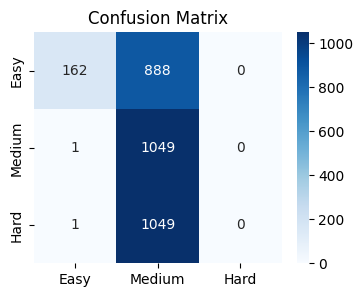

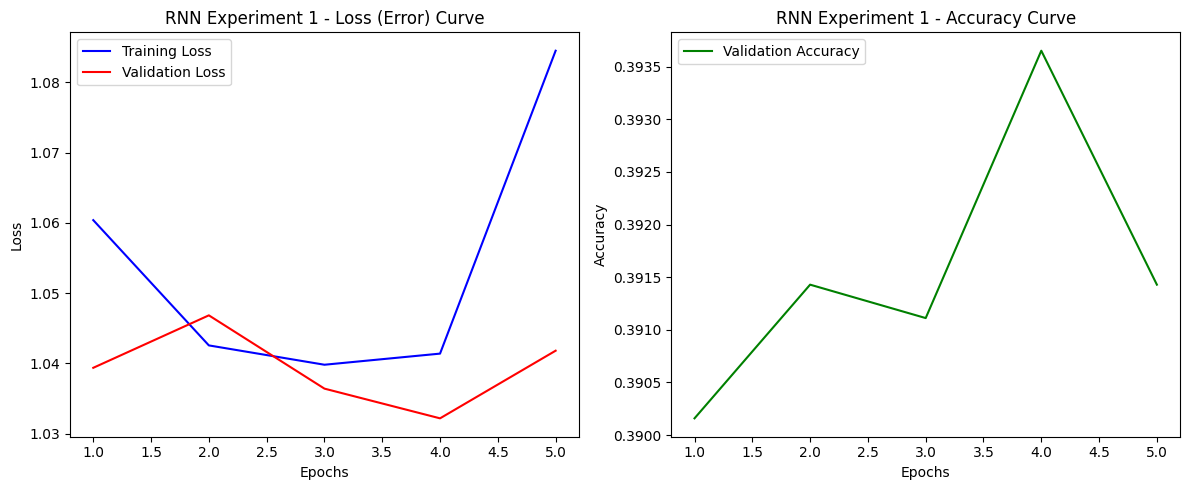

In [61]:
# הגדרות ספציפיות לניסוי
MODEL_TYPE = 'RNN'
IS_BIDIRECTIONAL = False
EMBED_MAT = None # מאומן מאפס

# א. הגדרת המודל
model_1 = FlexibleModel(36543, 100, 128, 3, n_layers=1,
                        model_type=MODEL_TYPE, bidirectional=IS_BIDIRECTIONAL, embedding_matrix=EMBED_MAT)

# ב. אימון המודל
print(f"מתחיל ניסוי: {MODEL_TYPE}, Bidirectional={IS_BIDIRECTIONAL}")
history_1 = run_experiment(model_1, train_loader, val_loader, epochs=5)

# ג. הערכת ביצועים
print_evaluation_section_c(model_1, test_loader)


# הדפסת הגרף של סעיף ב.2
plot_training_history(history_1, model_name="RNN Experiment 1")


**RNN - GloVe frozen**

מתחיל ניסוי 2: RNN, Embedding=GloVe Frozen


/tmp/ipython-input-1411159259.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))


Epoch 1: Train Loss: 1.0010, Val Loss: 1.0024, Val Acc: 0.4432
Epoch 2: Train Loss: 1.0038, Val Loss: 1.0047, Val Acc: 0.4317
Epoch 3: Train Loss: 0.9919, Val Loss: 1.0116, Val Acc: 0.4429
Epoch 4: Train Loss: 0.9926, Val Loss: 1.0156, Val Acc: 0.4203
Epoch 5: Train Loss: 0.9825, Val Loss: 0.9853, Val Acc: 0.4457


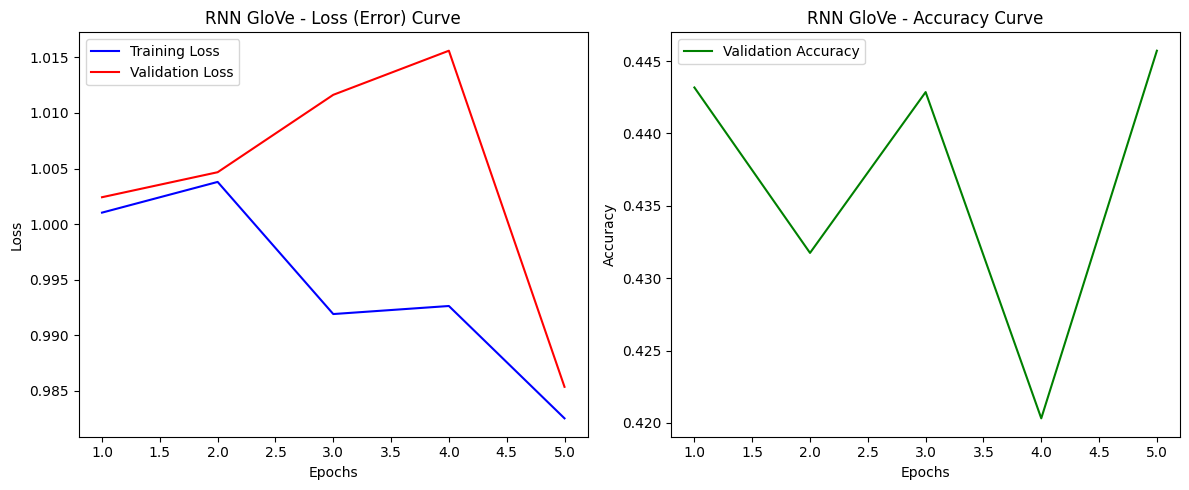


סעיף ג: הערכת ביצועים
              precision    recall  f1-score   support

        Easy       0.80      0.39      0.52      1050
      Medium       0.00      0.00      0.00      1050
        Hard       0.38      0.95      0.54      1050

    accuracy                           0.45      3150
   macro avg       0.39      0.45      0.35      3150
weighted avg       0.39      0.45      0.35      3150



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


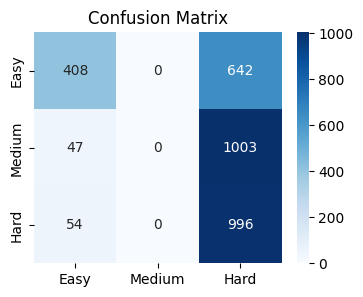

In [62]:
# ניסוי 2: RNN + GloVe (Frozen)
MODEL_TYPE = 'RNN'
IS_BIDIRECTIONAL = False
EMBED_MAT = embedding_weights # וודאו שמשתנה זה הוגדר בשלב ה-Embedding

print(f"מתחיל ניסוי 2: {MODEL_TYPE}, Embedding=GloVe Frozen")
model_2 = FlexibleModel(36543, 100, 128, 3, n_layers=1, model_type=MODEL_TYPE, bidirectional=IS_BIDIRECTIONAL, embedding_matrix=EMBED_MAT)
history_2 = run_experiment(model_2, train_loader, test_loader, epochs=5)

plot_training_history(history_2, model_name="RNN GloVe")
print_evaluation_section_c(model_2, test_loader)

**LSTM - Regular embedding**

מתחיל ניסוי 3: LSTM, Embedding=Scratch
Epoch 1: Train Loss: 1.0024, Val Loss: 0.9870, Val Acc: 0.4492
Epoch 2: Train Loss: 0.9714, Val Loss: 0.9850, Val Acc: 0.4505
Epoch 3: Train Loss: 0.9574, Val Loss: 0.9581, Val Acc: 0.4606
Epoch 4: Train Loss: 0.9267, Val Loss: 0.9447, Val Acc: 0.4851
Epoch 5: Train Loss: 0.8884, Val Loss: 0.9272, Val Acc: 0.5146


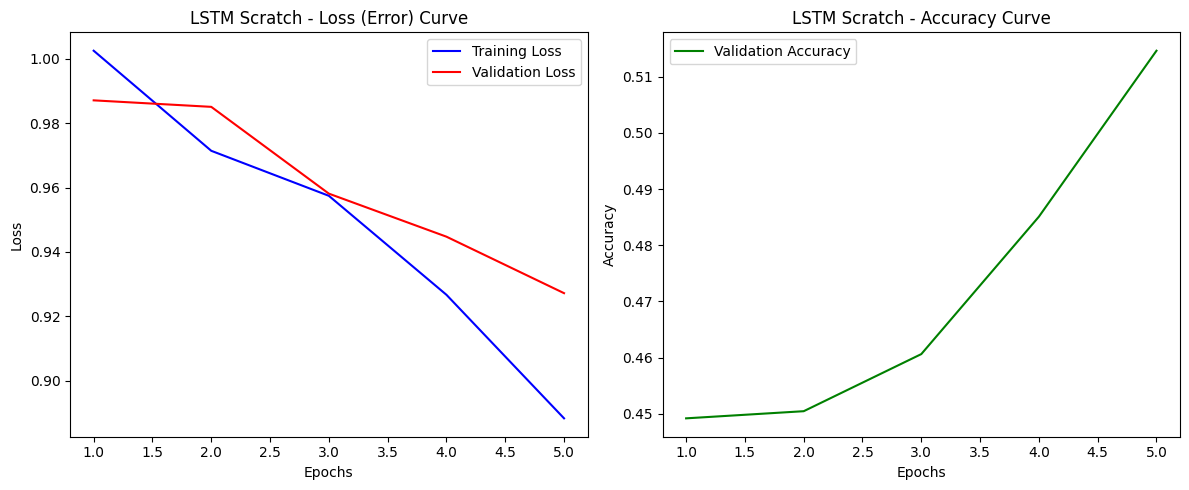


סעיף ג: הערכת ביצועים
              precision    recall  f1-score   support

        Easy       0.74      0.59      0.66      1050
      Medium       0.46      0.40      0.43      1050
        Hard       0.42      0.56      0.48      1050

    accuracy                           0.51      3150
   macro avg       0.54      0.51      0.52      3150
weighted avg       0.54      0.51      0.52      3150



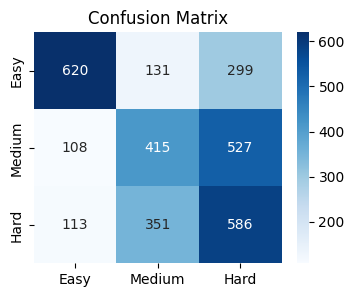

In [63]:
# ניסוי 3: LSTM + Trained from scratch
MODEL_TYPE = 'LSTM'
IS_BIDIRECTIONAL = False
EMBED_MAT = None

print(f"מתחיל ניסוי 3: {MODEL_TYPE}, Embedding=Scratch")
model_3 = FlexibleModel(36543, 100, 128, 3, n_layers=1, model_type=MODEL_TYPE, bidirectional=IS_BIDIRECTIONAL, embedding_matrix=EMBED_MAT)
history_3 = run_experiment(model_3, train_loader, test_loader, epochs=5)

plot_training_history(history_3, model_name="LSTM Scratch")
print_evaluation_section_c(model_3, test_loader)

**LSTM - GloVe frozen**

מתחיל ניסוי 4: LSTM, Embedding=GloVe Frozen


/tmp/ipython-input-1411159259.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))


Epoch 1: Train Loss: 0.9816, Val Loss: 0.9875, Val Acc: 0.4562
Epoch 2: Train Loss: 0.9722, Val Loss: 0.9761, Val Acc: 0.4606
Epoch 3: Train Loss: 0.9597, Val Loss: 0.9795, Val Acc: 0.4711
Epoch 4: Train Loss: 0.9393, Val Loss: 0.9486, Val Acc: 0.4886
Epoch 5: Train Loss: 0.9313, Val Loss: 0.9257, Val Acc: 0.4978


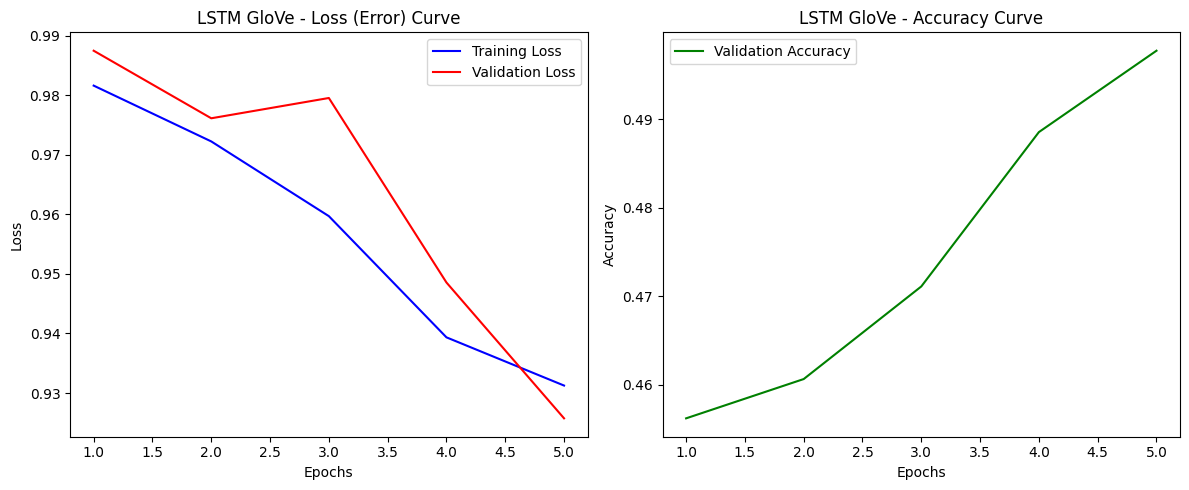


סעיף ג: הערכת ביצועים
              precision    recall  f1-score   support

        Easy       0.74      0.58      0.65      1050
      Medium       0.41      0.36      0.38      1050
        Hard       0.42      0.56      0.48      1050

    accuracy                           0.50      3150
   macro avg       0.52      0.50      0.50      3150
weighted avg       0.52      0.50      0.50      3150



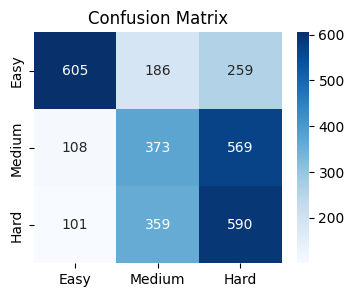

In [64]:
# ניסוי 4: LSTM + GloVe (Frozen)
MODEL_TYPE = 'LSTM'
IS_BIDIRECTIONAL = False
EMBED_MAT = embedding_weights

print(f"מתחיל ניסוי 4: {MODEL_TYPE}, Embedding=GloVe Frozen")
model_4 = FlexibleModel(36543, 100, 128, 3, n_layers=1, model_type=MODEL_TYPE, bidirectional=IS_BIDIRECTIONAL, embedding_matrix=EMBED_MAT)
history_4 = run_experiment(model_4, train_loader, test_loader, epochs=5)

plot_training_history(history_4, model_name="LSTM GloVe")
print_evaluation_section_c(model_4, test_loader)

**BiLSTM - regular embedding**

מתחיל ניסוי 5: LSTM, Bidirectional=True, Embedding=Scratch
Epoch 1: Train Loss: 0.9550, Val Loss: 0.9034, Val Acc: 0.5143
Epoch 2: Train Loss: 0.8861, Val Loss: 0.8809, Val Acc: 0.5308
Epoch 3: Train Loss: 0.8508, Val Loss: 0.8816, Val Acc: 0.5317
Epoch 4: Train Loss: 0.8120, Val Loss: 0.8858, Val Acc: 0.5422
Epoch 5: Train Loss: 0.7655, Val Loss: 0.9217, Val Acc: 0.5394
Epoch 6: Train Loss: 0.7115, Val Loss: 0.9939, Val Acc: 0.5356
Epoch 7: Train Loss: 0.6611, Val Loss: 1.0039, Val Acc: 0.5330
Epoch 8: Train Loss: 0.6106, Val Loss: 1.0598, Val Acc: 0.5324
Epoch 9: Train Loss: 0.5468, Val Loss: 1.1412, Val Acc: 0.5184
Epoch 10: Train Loss: 0.4975, Val Loss: 1.1843, Val Acc: 0.5121


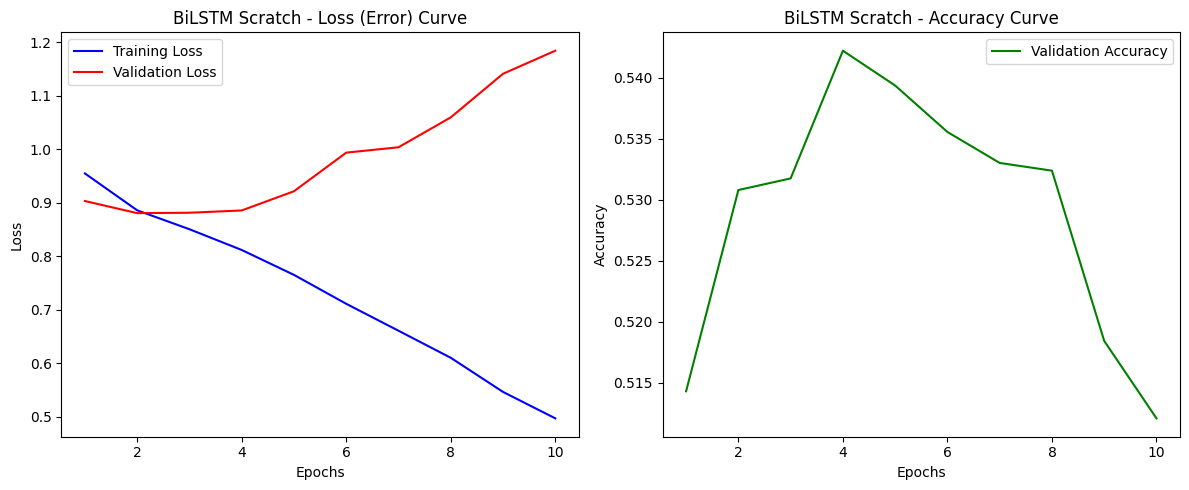


סעיף ג: הערכת ביצועים
              precision    recall  f1-score   support

        Easy       0.67      0.68      0.67      1050
      Medium       0.44      0.50      0.47      1050
        Hard       0.42      0.36      0.38      1050

    accuracy                           0.51      3150
   macro avg       0.51      0.51      0.51      3150
weighted avg       0.51      0.51      0.51      3150



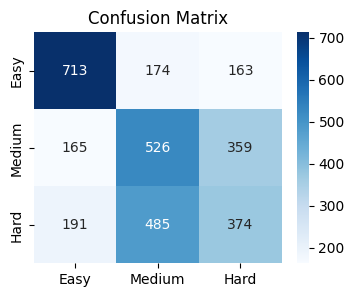

In [67]:
# --- ניסוי 5: BiLSTM + Embedding (Trained from Scratch) ---
MODEL_TYPE = 'LSTM'
IS_BIDIRECTIONAL = True
EMBED_MAT = None # המודל ייצור משקולות אקראיות וילמד אותן

print(f"מתחיל ניסוי 5: {MODEL_TYPE}, Bidirectional={IS_BIDIRECTIONAL}, Embedding=Scratch")

# יצירת המודל (שימו לב ש-EMBED_MAT הוא None)
model_5 = FlexibleModel(VOCAB_SIZE, 100, 128, 3, n_layers=1,
                        model_type=MODEL_TYPE,
                        bidirectional=IS_BIDIRECTIONAL,
                        embedding_matrix=EMBED_MAT)

# הרצת אימון
history_5 = run_experiment(model_5, train_loader, val_loader, epochs=10)

# הצגת תוצאות
plot_training_history(history_5, model_name="BiLSTM Scratch")
print_evaluation_section_c(model_5, val_loader)

**Frozen BiLSTM - GloVe**

מתחיל ניסוי 6: LSTM, Bidirectional=True, Embedding=GloVe Frozen


/tmp/ipython-input-1411159259.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))


Epoch 1: Train Loss: 0.9494, Val Loss: 0.9038, Val Acc: 0.4971
Epoch 2: Train Loss: 0.9070, Val Loss: 0.8898, Val Acc: 0.5257
Epoch 3: Train Loss: 0.8875, Val Loss: 0.8778, Val Acc: 0.5238
Epoch 4: Train Loss: 0.8694, Val Loss: 0.8871, Val Acc: 0.5238
Epoch 5: Train Loss: 0.8577, Val Loss: 0.8685, Val Acc: 0.5267
Epoch 6: Train Loss: 0.8384, Val Loss: 0.8715, Val Acc: 0.5279
Epoch 7: Train Loss: 0.8200, Val Loss: 0.8886, Val Acc: 0.5381
Epoch 8: Train Loss: 0.8033, Val Loss: 0.8792, Val Acc: 0.5337
Epoch 9: Train Loss: 0.7862, Val Loss: 0.8981, Val Acc: 0.5340
Epoch 10: Train Loss: 0.7653, Val Loss: 0.9028, Val Acc: 0.5314


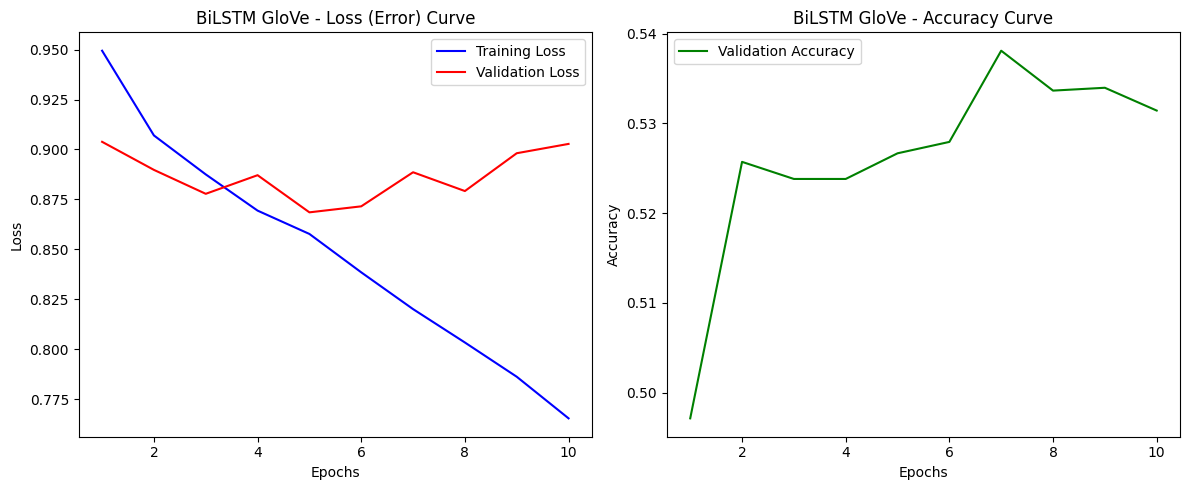


סעיף ג: הערכת ביצועים
              precision    recall  f1-score   support

        Easy       0.83      0.60      0.69      1050
      Medium       0.45      0.45      0.45      1050
        Hard       0.42      0.55      0.48      1050

    accuracy                           0.53      3150
   macro avg       0.57      0.53      0.54      3150
weighted avg       0.57      0.53      0.54      3150



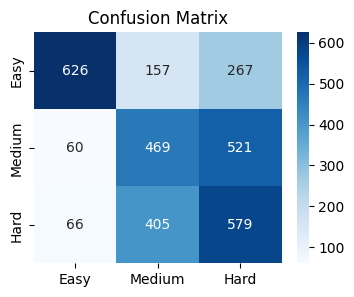

In [68]:
# --- ניסוי 6: BiLSTM + GloVe (Frozen) ---
MODEL_TYPE = 'LSTM'
IS_BIDIRECTIONAL = True
EMBED_MAT = embedding_weights # שימוש במטריצה שטענתם מראש

print(f"מתחיל ניסוי 6: {MODEL_TYPE}, Bidirectional={IS_BIDIRECTIONAL}, Embedding=GloVe Frozen")

# יצירת המודל
model_6 = FlexibleModel(VOCAB_SIZE, 100, 128, 3, n_layers=1,
                        model_type=MODEL_TYPE,
                        bidirectional=IS_BIDIRECTIONAL,
                        embedding_matrix=EMBED_MAT)

# הרצת אימון
history_6 = run_experiment(model_6, train_loader, val_loader, epochs=10)

# הצגת תוצאות
plot_training_history(history_6, model_name="BiLSTM GloVe")
print_evaluation_section_c(model_6, val_loader)